In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os
from convection_param.HelperFuncs import *
from convection_param.ConvParamFuncs import *
from convection_param.GetTrainingData import *

xr.set_options(display_style="html");
%load_ext autoreload
%autoreload 2

In [2]:
data = np.load('../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct.npz')

X_train, X_val, X_test, Y_train, Y_val, Y_test, X_expl, Y_expl = \
data['X_train'], data['X_val'], data['X_test'], data['Y_train'], data['Y_val'], data['Y_test'], data['X_expl'], data['Y_expl']

# vars_to_neglect = ['qr','qi','qs']
# vars_to_neglect = ['qr','qs']
vars_to_neglect = []

files = [f for f in os.scandir('../Models/Optimized/20230421-1613616samples/')]
# files = [f for f in os.scandir('../Models/Optimized/20230504-1613616samples_woqrqs/')]

vars_to_neglect_mask = ~np.isin(unique_unsorted([e[0] for e in X_expl]), vars_to_neglect)
print(vars_to_neglect_mask)
X_train = X_train[:,:,vars_to_neglect_mask]
X_val = X_val[:,:,vars_to_neglect_mask]
X_test = X_test[:,:,vars_to_neglect_mask]
X_expl = np.array([e for e in X_expl if e[0] not in vars_to_neglect])

print(data.files)

[ True  True  True  True  True  True  True  True  True]
['X_train', 'X_val', 'X_test', 'Y_train', 'Y_val', 'Y_test', 'X_expl', 'Y_expl', 'train_coords', 'val_coords', 'test_coords']


In [3]:
to_drop = ['LassoLars']#[]#
df_R2 = pd.concat([pd.read_csv(f.path, index_col=0) for f in files if 'df_R2_test' in f.name], axis=1)
df_RMSE = pd.concat([pd.read_csv(f.path, index_col=0) for f in files if 'df_RMSE_test' in f.name], axis=1)
sample_sizes = pd.DataFrame([1 for _ in range(len(df_R2.columns))], index=df_R2.columns)

In [4]:
models = list(df_R2.columns)

In [5]:
def repeat_list_until_length(orig_list, n):
    n_reps = int(np.ceil(n/len(color_cycle)))
    return (color_cycle*n_reps)[:n]
    
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = np.array(repeat_list_until_length(color_cycle, len(models)))

In [6]:
json_file = '../DL_test_results.json'
DL_R2_varw = pd.read_json(json_file, orient='index')['R2']
DL_RMSE_varw = pd.read_json(json_file, orient='index')['RMSE']
DL_R2_varw

Unet      0.898259
Resnet    0.894392
Mlp       0.887575
Conv      0.877186
LinMlp    0.632055
Name: R2, dtype: float64

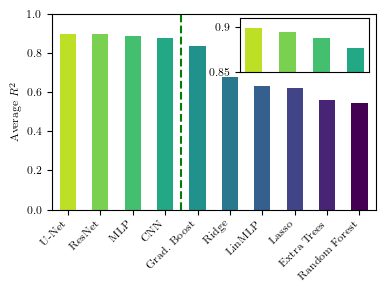

In [12]:
%matplotlib inline
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.style.use('default')
setup_mpl_tex()

def get_sample_size(idx):
    if idx in sample_sizes.keys():
        return sample_sizes[idx].item()
    return 0.1#X_train.shape[0]
        

fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('halfa4'))
# av_R2 = df_R2.mean()
var_Y_test = np.var(Y_test, axis=0)
av_R2_varw = df_R2.apply(lambda x: np.average(x, weights=var_Y_test))
# av_R2_varw = av_R2_varw.drop('LinearRegression')

av_R2_varw = pd.concat([av_R2_varw, DL_R2_varw])
av_R2_varw = av_R2_varw.drop(to_drop, axis=0).sort_values(ascending=False)

# model_colors = np.array([plt.get_cmap('viridis')(score/(av_R2_varw.max()+0.1)) for score in av_R2_varw])
def scale_to_0_1(x,x_min,x_max):
    return (x-x_min)/(x_max-x_min)*0.9

# model_colors = np.array([plt.get_cmap('viridis')(scale_to_0_1(score, av_R2_varw.min(), av_R2_varw.max())) for score in av_R2_varw])
model_colors = np.array([plt.get_cmap('viridis')(i/len(av_R2_varw)) for i,score in enumerate(av_R2_varw)])[::-1]

idx_sorted = np.argsort(av_R2_varw)[::-1]
av_R2_varw.plot(kind='bar', ylabel=r'Average $R^2$', ax=ax, color=model_colors[idx_sorted])
# df_R2.mean().sort_values(ascending=False).plot(kind='bar', ylabel=r'Average $R^2$', ax=ax)
ax.axvline(3.5, ls='--', color='green')
plt.xticks(rotation=45, ha='right')

# inset axes....
x1, x2, y1, y2 = -0.4, 3.4, 0.85, 0.91  # subregion of the original image
axins = ax.inset_axes([5.3, 0.7, 4, 0.28], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[], transform=ax.transData)
av_R2_varw.iloc[:4].plot(kind='bar', yticks=[0.85,0.9], xticks=[], ax=axins, color=model_colors[idx_sorted])
axins.set_xlim(-0.4,3.4)
axins.set_yticklabels([0.85,0.9])

xticklabels = ax.get_xticklabels()
def map_if_in_keys(key, dictionary):
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return key

model_name_display_map = {'HistGradientBoostingRegressor': 'Grad. Boost',
                          'MultiTaskElasticNet': 'Elastic Net',
                          'MultiTaskLasso': 'Lasso',
                          'ExtraTreesRegressor': 'Extra Trees',
                          'RandomForestRegressor': 'Random Forest',
                          'LinearRegression': 'Linear Regr.',
                          'LinMlp': 'LinMLP',
                          'Conv': 'CNN',
                          'Unet': 'U-Net',
                          'Resnet': 'ResNet',
                          'Mlp': 'MLP'}

for label in xticklabels:
    label.set_text(map_if_in_keys(label.get_text(), model_name_display_map))
ax.set_xticklabels(xticklabels)
plt.ylim(0, 1)

plt.show()

In [8]:
av_R2_varw

Unet                             0.898259
Resnet                           0.894392
Mlp                              0.887575
Conv                             0.877186
HistGradientBoostingRegressor    0.835200
Ridge                            0.676826
LinMlp                           0.632055
MultiTaskLasso                   0.618083
ExtraTreesRegressor              0.560225
RandomForestRegressor            0.544887
dtype: float64